In [1]:
# IMPORT MODULES

# Pandas
import pandas as pd

# Numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# Ipython tool for figsize
from IPython.core.pylabtools import figsize

# train test split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline

# DictVectorizer to convert categorical features
from sklearn.feature_extraction import DictVectorizer

# XGB Classifier
import xgboost as xgb

# cross_val_score
from sklearn.model_selection import cross_val_score

# Imputer
from sklearn.preprocessing import Imputer

# FeatureUnion
from sklearn.pipeline import FeatureUnion

# Function Transformer
from sklearn.preprocessing import FunctionTransformer

# ROC AUC
from sklearn.metrics import roc_auc_score, roc_curve



In [2]:
# EXPLORE THE DATA

# Read the file into df
df_train = pd.read_csv('.../titanic/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# view the data types of each feature
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
# get some info about the data
df_train.info() # it appears age, cabin and embarked are missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Take a look at the descriptive statistics
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 1.0, 'Age Distribution')

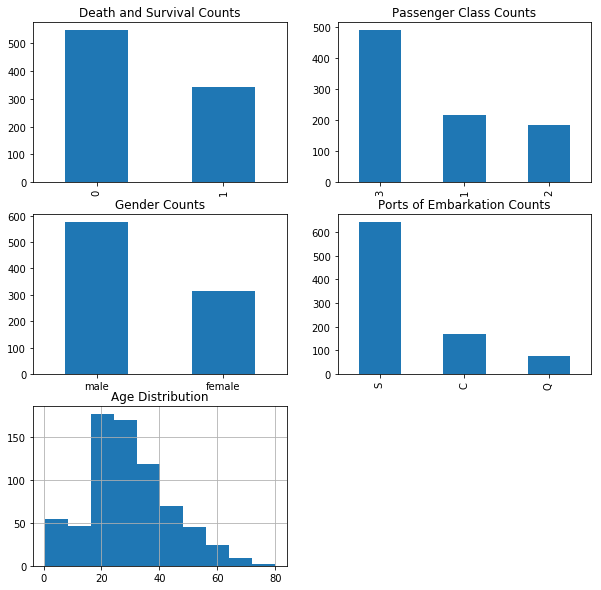

In [6]:
# EXPLORATORY DATA ANALYSIS

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 10)

# Size of matplotlib histogram bins
bin_size = 10

# Set up a grid of plots
fig = plt.figure(figsize=fizsize_with_subplots) 
fig_dims = (3, 2)

# Plot death and survival counts
plt.subplot2grid(fig_dims, (0, 0))
df_train['Survived'].value_counts().plot(kind='bar', 
                                         title='Death and Survival Counts')

# Plot Pclass counts
plt.subplot2grid(fig_dims, (0, 1))
df_train['Pclass'].value_counts().plot(kind='bar', 
                                       title='Passenger Class Counts')

# Plot Sex counts
plt.subplot2grid(fig_dims, (1, 0))
df_train['Sex'].value_counts().plot(kind='bar', 
                                    title='Gender Counts')
plt.xticks(rotation=0)

# Plot Embarked counts
plt.subplot2grid(fig_dims, (1, 1))
df_train['Embarked'].value_counts().plot(kind='bar', 
                                         title='Ports of Embarkation Counts')

# Plot the Age histogram
plt.subplot2grid(fig_dims, (2, 0))
df_train['Age'].hist()
plt.title('Age Distribution')

In [7]:
# Effect of Passenger Classes on Survival
# Proportion of Survivors in each class
# cross tab of Pclass and Survived
pclass_ct = pd.crosstab(df_train['Pclass'], df_train['Survived'])
pclass_ct

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Text(0, 0.5, 'Survival Percentage')

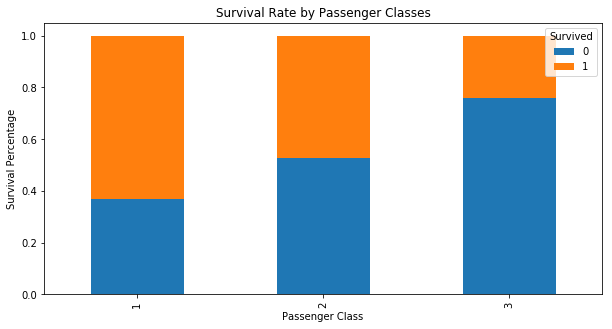

In [8]:
# Normalize the cross tab to sum to 1:
pclass_ct_pct = pclass_ct.div(pclass_ct.sum(1).astype(float), axis=0)

pclass_ct_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Survival Rate by Passenger Classes')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Percentage')
# It is very obvious those in first class had the highest
# rate of survival and less number of deaths as compared 
# to the other classes

In [9]:
# Effect of Sex on Survival
# mapping of sex from string to number value
sexes = sorted(df_train['Sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
print(genders_mapping)

df_train['Sex_Num'] = df_train['Sex'].map(genders_mapping).astype(int)
df_train.head()

{'female': 0, 'male': 1}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


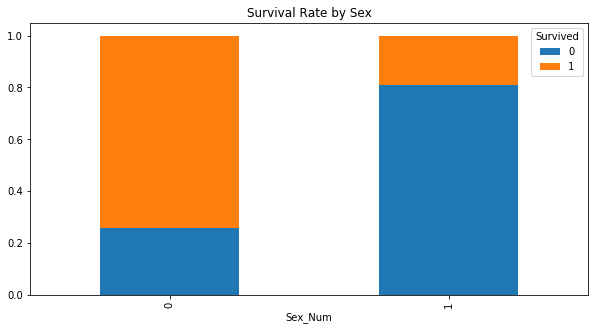

In [10]:
# Proportion of Survivors in each class
# cross tab of Pclass and Survived
# Normalize the cross tab to sum to 1:
sex_num_xt = pd.crosstab(df_train['Sex_Num'], df_train['Survived'])
sex_num_xt_pct = sex_num_xt.div(sex_num_xt.sum(1).astype(float), axis=0)
sex_num_xt_pct.plot(kind='bar', stacked=True, title='Survival Rate by Sex')

# We can see from the plot that gender played a role on survival rate
# females had a higher survival rate than the men

In [11]:
# Effect of Survival rate in each class by sex
# Get the unique values of Pclass:
passenger_classes = sorted(df_train['Pclass'].unique())

for p_class in passenger_classes:
    print('M: ', p_class, len(df_train[(df_train['Sex'] == 'male') & 
                             (df_train['Pclass'] == p_class)])) 
    print('F: ', p_class, len(df_train[(df_train['Sex'] == 'female') & 
                             (df_train['Pclass'] == p_class)])) 

M:  1 122
F:  1 94
M:  2 108
F:  2 76
M:  3 347
F:  3 144


Text(0, 0.5, 'Survival Rate')

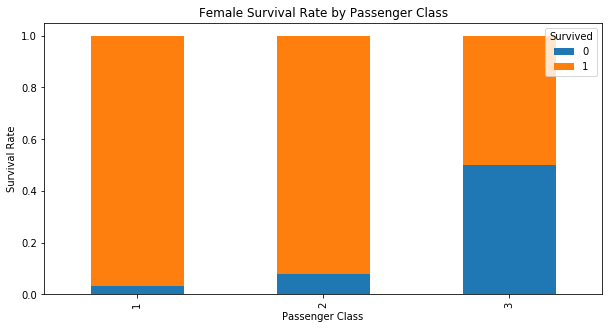

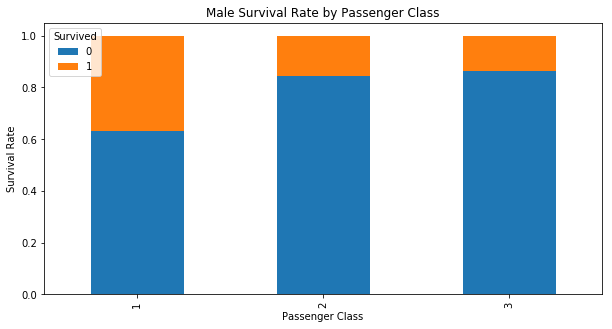

In [12]:
# Plot survival rate by Sex
females_df = df_train[df_train['Sex'] == 'female']
females_xt = pd.crosstab(females_df['Pclass'], df_train['Survived'])
females_xt_pct = females_xt.div(females_xt.sum(1).astype(float), axis=0)
females_xt_pct.plot(kind='bar', 
                    stacked=True, 
                    title='Female Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# Plot survival rate by Pclass
males_df = df_train[df_train['Sex'] == 'male']
males_xt = pd.crosstab(males_df['Pclass'], df_train['Survived'])
males_xt_pct = males_xt.div(males_xt.sum(1).astype(float), axis=0)
males_xt_pct.plot(kind='bar', 
                  stacked=True, 
                  title='Male Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# Majority of females survived in the first and second classes
# Majority of men died in the second and thrid classes

In [13]:
# Effect of Age on Survival
# since Age is missing some values, populate age
# but keep original feature
df_train['AgeFill'] = df_train['Age']

df_train['AgeFill'] = df_train['AgeFill'] \
                        .groupby([df_train['Sex_Num'], df_train['Pclass']]) \
                        .apply(lambda x: x.fillna(x.median()))

In [14]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Num,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,35.0


In [15]:
# Bins to group ages
bins = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_train['Age_group'] = pd.cut(df_train['AgeFill'], range(0, 81, 10), right=False, labels=bins)

In [16]:
# Data of survivors and non-survivors
df_survivors = df_train[df_train['Survived']==True]
df_non_survivors = df_train[df_train['Survived']==False]

In [17]:
# This is a function to calculate the percentages
def as_percent(val, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(val, Number):
        return "{{:{}%}}".format(precision).format(val)
    else:
        raise TypeError("Numeric type required")

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

In [18]:
# How many people survived in each age group
survivors_agegroup = df_survivors.groupby(['Age_group']).size().values
non_survivors_agegroup = df_non_survivors.groupby(['Age_group']).size().values

# To calculate the percentage by gender, we need the totals
total = survivors_agegroup + non_survivors_agegroup

# Calculate the percentage of survival by agegroup
survived_agegroup_percent = calculate_percentage(survivors_agegroup, total)*100
non_survived_agegroup_percent = calculate_percentage(non_survivors_agegroup, total)*100

print(survivors_agegroup)
print(non_survivors_agegroup)
print(total)
print(survived_agegroup_percent)
print(non_survived_agegroup_percent)

[ 38  41 113  84  39  20   6   0]
[ 24  61 245 101  71  28  13   6]
[ 62 102 358 185 110  48  19   6]
[61.29032258 40.19607843 31.56424581 45.40540541 35.45454545 41.66666667
 31.57894737  0.        ]
[ 38.70967742  59.80392157  68.43575419  54.59459459  64.54545455
  58.33333333  68.42105263 100.        ]


Text(0.5, 1.0, '% of Survivors by Agegroup')

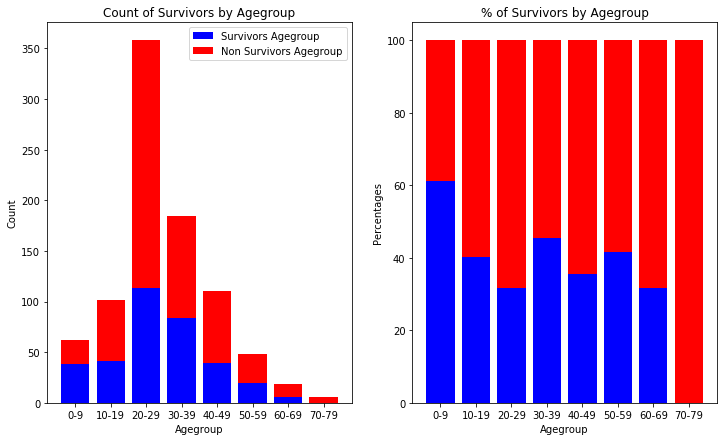

In [19]:
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(12, 7))


# Plot of survival by age group
ax5.bar(range(len(survivors_agegroup)), survivors_agegroup, label="Survivors Agegroup", color='b')
ax5.bar(range(len(non_survivors_agegroup)), non_survivors_agegroup, bottom=survivors_agegroup, label="Non Survivors Agegroup", color='r')
plt.sca(ax5)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], bins)
ax5.set_ylabel("Count")
ax5.set_xlabel("Agegroup")
ax5.set_title("Count of Survivors by Agegroup")
plt.legend(loc='best')

# Percentage of Survival by agegroup
ax6.bar(range(len(survived_agegroup_percent)), survived_agegroup_percent, color='b')
ax6.bar(range(len(non_survived_agegroup_percent)), non_survived_agegroup_percent, bottom=survived_agegroup_percent, color='r')
plt.sca(ax6)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], bins)
ax6.set_ylabel("Percentages")
ax6.set_xlabel("Agegroup")
ax6.set_title("% of Survivors by Agegroup")

# From the graph below it shows most survivors are aged between 20s and early 30s

In [20]:
# Feature Engineering

# we combine number of parents, children and siblings
# to one feature
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Num,AgeFill,Age_group,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,22.0,20-29,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,38.0,30-39,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26.0,20-29,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,35.0,30-39,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,35.0,30-39,0


Text(0, 0.5, 'Count/Frequency')

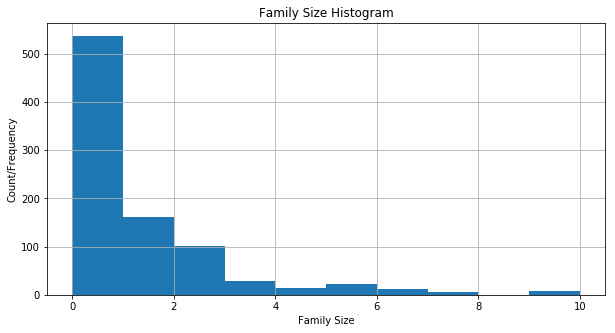

In [21]:
# Distribution of family size
df_train['FamilySize'].hist()
plt.title('Family Size Histogram')
plt.xlabel('Family Size')
plt.ylabel('Count/Frequency')

# We don't really see an effect by FamilySize on survival. This distribution is really
# skewed and doesn't show normal distribution

In [22]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Num,AgeFill,Age_group,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,22.0,20-29,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,38.0,30-39,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26.0,20-29,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,35.0,30-39,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,35.0,30-39,0


In [23]:
# DATA PREPARATION FOR ML

# Drop columns we don't need
col_drop = ['Name', 'Sex_Num', 'Ticket', 'Cabin', 'AgeFill', 'Age_group', 'SibSp', 
            'Parch', 'PassengerId']

df_train = df_train.drop(col_drop, axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [24]:
# Seperating data to features and target
# X and y
X = df_train.drop(columns=['Survived'])
y= df_train['Survived']

In [25]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [26]:
X.dtypes

Pclass          int64
Sex            object
Age           float64
Fare          float64
Embarked       object
FamilySize      int64
dtype: object

In [27]:
# Get numerical and categorical features
num_cols = ['Pclass','Age', 'Fare', 'FamilySize']
cat_cols = X.columns.drop(num_cols)
print(num_cols)
print(cat_cols)

['Pclass', 'Age', 'Fare', 'FamilySize']
Index(['Sex', 'Embarked'], dtype='object')


In [28]:
# define numerical imputer
num_imputer = Imputer(strategy='median')

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
# imputing on numerical data
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [30]:
# Function for CategoricalImputer
# Imputing missing categorical data
# with the most frequent value

from sklearn_pandas import CategoricalImputer

# categorical_imputer
class Categorical_Imputer:
    """
    Imputing categorical data using the most frequent value
    """
    
    # instance attribute
    def __init__(self, strategy):
        self.strategy = strategy
        
    # instance method
    def fit_transform(self, df:'dataframe')->'dataframe':
        """
        Fill in missing categorical values using most frequent value
        """
        
        # instantiate CategoricalImputer
        imputer = CategoricalImputer()
        
        # convert array to dataframe
        df_filled = df.apply(lambda x: imputer.fit_transform(x), axis=0)
        
        # return filled dataframe
        return df_filled

# define categorical imputer
cate_imputer = Categorical_Imputer('most_frequent')

In [31]:
# imputing on categorical data
X[cat_cols] = cate_imputer.fit_transform(X[cat_cols])

In [32]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,3.0,male,22.0,7.2500,S,1.0
1,1.0,female,38.0,71.2833,C,1.0
2,3.0,female,26.0,7.9250,S,0.0
3,1.0,female,35.0,53.1000,S,1.0
4,3.0,male,35.0,8.0500,S,0.0


In [33]:
# Check once again if there's any missing data
X.columns[X.isna().any()].tolist()

[]

In [34]:
# Get dummies(convert all features to numerical values)
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

# take a snapshot of the converted data
X.head()

,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,3.0,22.0,7.2500,1.0,1,0,1
1,1.0,38.0,71.2833,1.0,0,0,0
2,3.0,26.0,7.9250,0.0,0,0,1
3,1.0,35.0,53.1000,1.0,0,0,1
4,3.0,35.0,8.0500,0.0,1,0,1


In [35]:
# FIT MODEL

# Split data to training and test sets

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(623, 7) (268, 7) (623,) (268,)


In [37]:
# Instantiate the XGBClassifier
# and fit the model
xgb_cl = xgb.XGBClassifier(random_state=42)
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
# Measure the accuracy of the model
y_pred_prob = xgb_cl.predict_proba(X_test)[:, 1]
# [:, 1]: the second value is the probability for 1(positive class)

In [39]:
y_pred_prob;

In [40]:
# Function to calculate and plot roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score, roc_curve

class roc_auc:
    """
    Calculate AUC score, Plot ROC curve
    """
    
    # instance attribute
    def __init__(self, y_test, y_pred_prob, model='model'):
        self.y_test = y_test
        self.y_pred_prob = y_pred_prob
        self.model = model
        
    # instance method
    def auc(self):
        """
        calculate auc score
        """
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        return auc_score
        
    # instance method
    def plot_roc(self):
        """
        plot roc curve
        """
        # AUC score
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        # fpr, tpr, threshold
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_prob)
        
        # ROC curve plot
        _ = plt.plot([0, 1], [0, 1], 'k--')
        _ = plt.plot(fpr, tpr, label= self.model + ' Classifier (AUC = {: .2f})'.format(auc_score))
        _ = plt.xlabel('False Positive Rate')
        _ = plt.ylabel('True Positive Rate')
        _ = plt.legend(loc='lower right')
        _ = plt.title(self.model + ' Classifier ROC Curve')
        _ = plt.show()

In [41]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='XGB')

In [42]:
ROC.auc()

0.8624595469255664

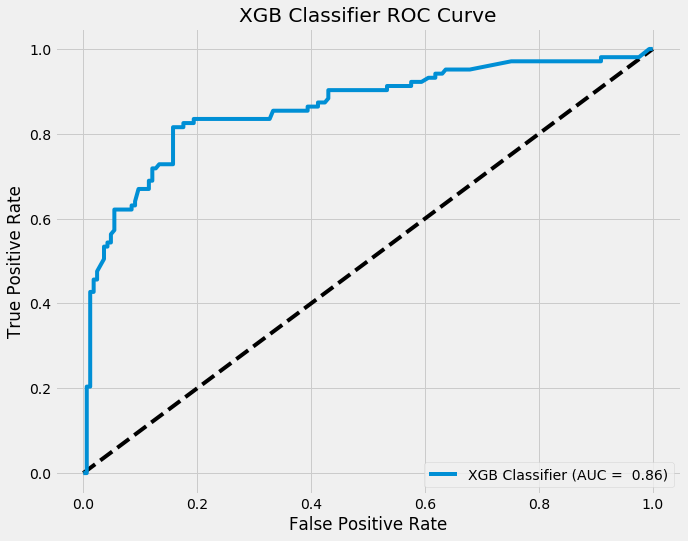

In [43]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

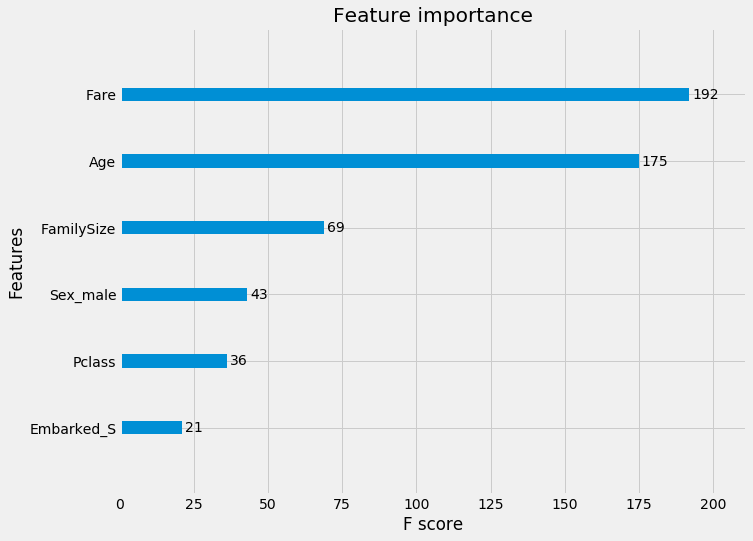

In [44]:
# Feature Importance
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot feature importance(Using built-In XGBOOST
# feature importance plot)
xgb.plot_importance(xgb_cl)

In [45]:
# Predict the test set

In [46]:
# load test set
df_test = pd.read_csv('.../titanic/test.csv')
df_test_pass = df_test['PassengerId']
df_test = df_test.drop(['PassengerId', 'Name'], axis=1)
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,3,female,47.0,1,0,363272,7.0000,NaN,S
2,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,3,male,27.0,0,0,315154,8.6625,NaN,S
4,3,female,22.0,1,1,3101298,12.2875,NaN,S


In [47]:
# Function to clean the test set
# based on the training set
def clean_data(df, drop_passenger_id):
    
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    num_cols = ['Pclass','Age', 'Fare', 'FamilySize']
    cat_cols = df.columns.drop(num_cols)
    
    # define numerical imputer
    num_imputer = Imputer(strategy='median')
    
    # imputing on numerical data
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    
    # define categorical imputer
    cate_imputer = Categorical_Imputer('most_frequent')
    
    # imputing on categorical data
    df[cat_cols] = cate_imputer.fit_transform(df[cat_cols])
    
    # Drop the columns we won't use.
    df = df.drop(['SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
    
    # Get dummies(convert all features to numerical values)
    df = pd.get_dummies(df, prefix_sep='_', drop_first=True)
    
    if drop_passenger_id:
        df = df.drop(['PassengerId'], axis=1)
    
    return df

In [48]:
test_x = clean_data(df_test, drop_passenger_id=False)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [49]:
# Predict survival values for the test data
y_pred = xgb_cl.predict(test_x)

In [50]:
# Write dataframe to csv
# for submission
submission = pd.DataFrame({ 'PassengerId': df_test_pass,'Survived': y_pred})
submission.to_csv('.../titanic/titanic_predictions.csv', index=False)